In [1]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Desktop/Classes/Research/deep_uncertainty/deep_uncertainty"))
from deep_uncertainty.evaluation.calibration import compute_mean_calibration, plot_regression_calibration_curve

# Bikes Data

Poisson

In [2]:
bikes = pd.read_csv('deep_uncertainty/data/bikes/hour.csv')
bikes = bikes[:1000]

In [3]:
bikes = bikes.drop(['dteday', 'instant', 'registered'], axis=1)
X = bikes.iloc[:,:-1]
mask = np.random.rand(len(bikes)) < 0.8
df_train = bikes[mask]
df_test = bikes[~mask]

expr = "cnt ~ " + " + ".join(bikes.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

In [4]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[ 11.,  41.],
       [ 12.,  43.],
       [ 99., 171.],
       [ 25.,  66.],
       [ 22.,  60.],
       [ 18.,  55.],
       [  3.,  25.],
       [  5.,  29.],
       [ 33.,  78.],
       [ 14.,  47.]])

In [5]:
y_test[:10].values

array([[  2.],
       [  8.],
       [106.],
       [ 35.],
       [ 37.],
       [ 34.],
       [  9.],
       [  3.],
       [ 93.],
       [ 59.]])

In [6]:
bikes['cnt'].mean()

58.304

In [7]:
bikes['cnt'].std()

50.985557867999354

In [8]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.4423005262200136

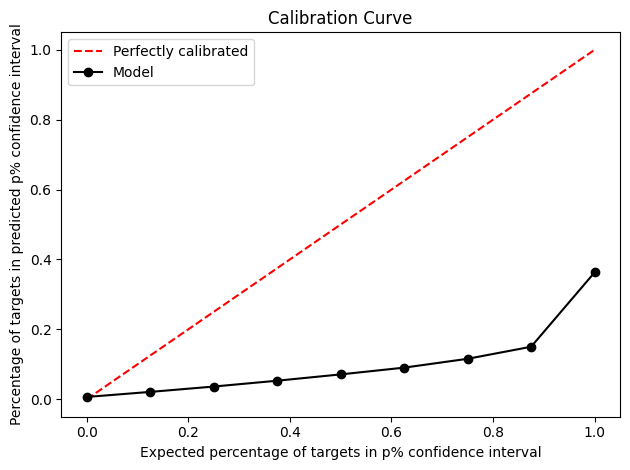

In [9]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

In [10]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_20799/4066697801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_20799/4066697801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_20799/4066697801.p

In [11]:
y_preds = predicted_counts
y_test = y_test['cnt']
# n is # of successes
n = successes
# p is the probability of success
p = successes / len(y_test)
posterior_predictive = nbinom(p=p, n=n)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[ 10., 735.],
       [ 10., 729.],
       [ 28., 551.],
       [ 17., 644.],
       [ 16., 655.],
       [ 17., 648.],
       [  5., 833.],
       [  6., 806.],
       [ 20., 612.],
       [ 12., 706.]])

In [12]:
y_test[:10].values

array([  2.,   8., 106.,  35.,  37.,  34.,   9.,   3.,  93.,  59.])

In [13]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.5161791489651513

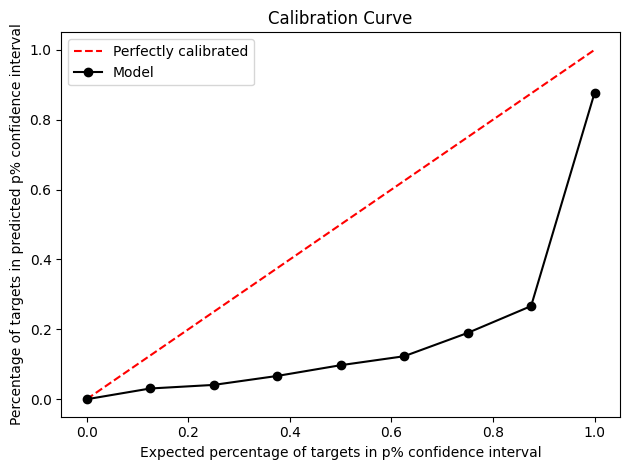

In [14]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

# Sales Data

Poisson

In [90]:
sales = pd.read_csv('deep_uncertainty/data/dominicks/cleaned_bath_counts.csv', low_memory=False)

In [91]:
sales = sales.drop(columns=['SALE', 'PRICE_HEX', 'PROFIT_HEX'], axis=1)
big_sales = sales.copy()

In [92]:
sales = sales[:10000]

In [93]:
from sklearn.preprocessing import LabelEncoder

big_sales = big_sales.apply(LabelEncoder().fit_transform)

sales = sales.apply(LabelEncoder().fit_transform)
sales

,UPC,STORE,WEEK,QTY,PRICE,PROFIT,OK,NAME,CITY,ZIP,...,GROUP4,GROUP5,GROUP6,GROUP7,GROUP8,GROUP9,GROUP10,GROUP11,GROUP12,MOVE
0,0,0,164,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,165,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,166,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,167,0,34,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,168,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,107,0,119,0,18,602,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9996,107,0,120,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,107,0,121,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,107,0,122,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
X = sales.iloc[:,:-1]
mask = np.random.rand(len(sales)) < 0.8
df_train = sales[mask]
df_test = sales[~mask]

expr = "MOVE ~ " + " + ".join(sales.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()

In [77]:
y_preds = poisson_training_results.mu
posterior_predictive = poisson(mu=y_preds)
posterior_predictive
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.]])

In [78]:
print(y_preds)

[0.07570935 0.07541296 0.07482367 ... 0.23617659 0.23525202 0.23433107]


In [79]:
y_test[:10].values

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.]])

In [80]:
sales['MOVE'].mean()

0.4286

In [81]:
sales['MOVE'].std()

1.0372124280792707

In [82]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.6396614950593351

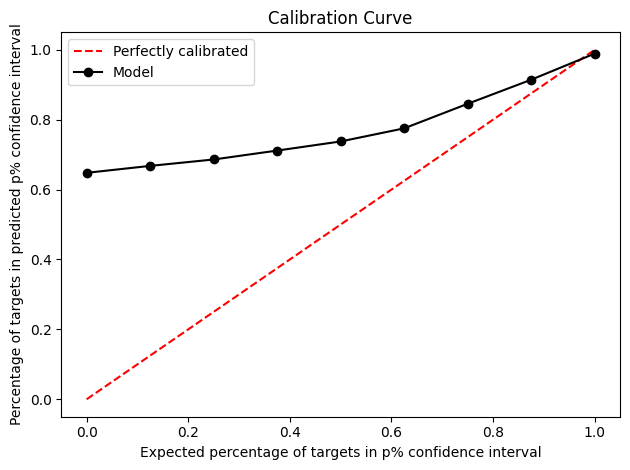

In [83]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

In [84]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['MOVE'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_20799/3350743688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_20799/3350743688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['MOVE'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_20799/3350743688.

In [85]:
successes

0      -3.002524
3      -2.112345
6      -3.033752
16     -3.106617
22     -3.137845
          ...   
9971   -0.264940
9978   -0.689360
9983   -1.446173
9985   -1.456582
9993    0.980228
Length: 2058, dtype: float64

In [87]:
y_preds = predicted_counts
y_test = y_test['MOVE']
# n is # of successes
n = successes
# p is the probability of success
p = successes / len(y_test)
posterior_predictive = nbinom(p=p, n=n)
len(y_preds)

2058

In [88]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.3596322496773473

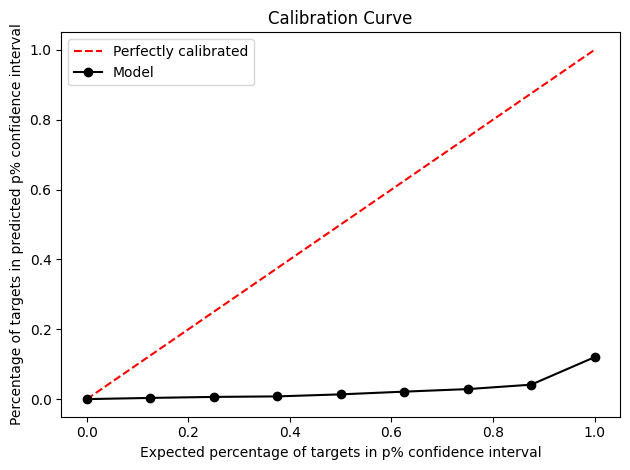

In [89]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)